# Introduction to preprocessing of respiration belt data using pyriodic

In [1]:
import numpy as np
from pyriodic.preproc import RawSignal
from pyriodic.phase_events import create_phase_events
from pyriodic.viz import plot_phase_diagnostics
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt

## Load in data and create `RawSignal` object


In [2]:
with open("../../data/respiration/example.pkl", "rb") as file:
    data = pickle.load(file)

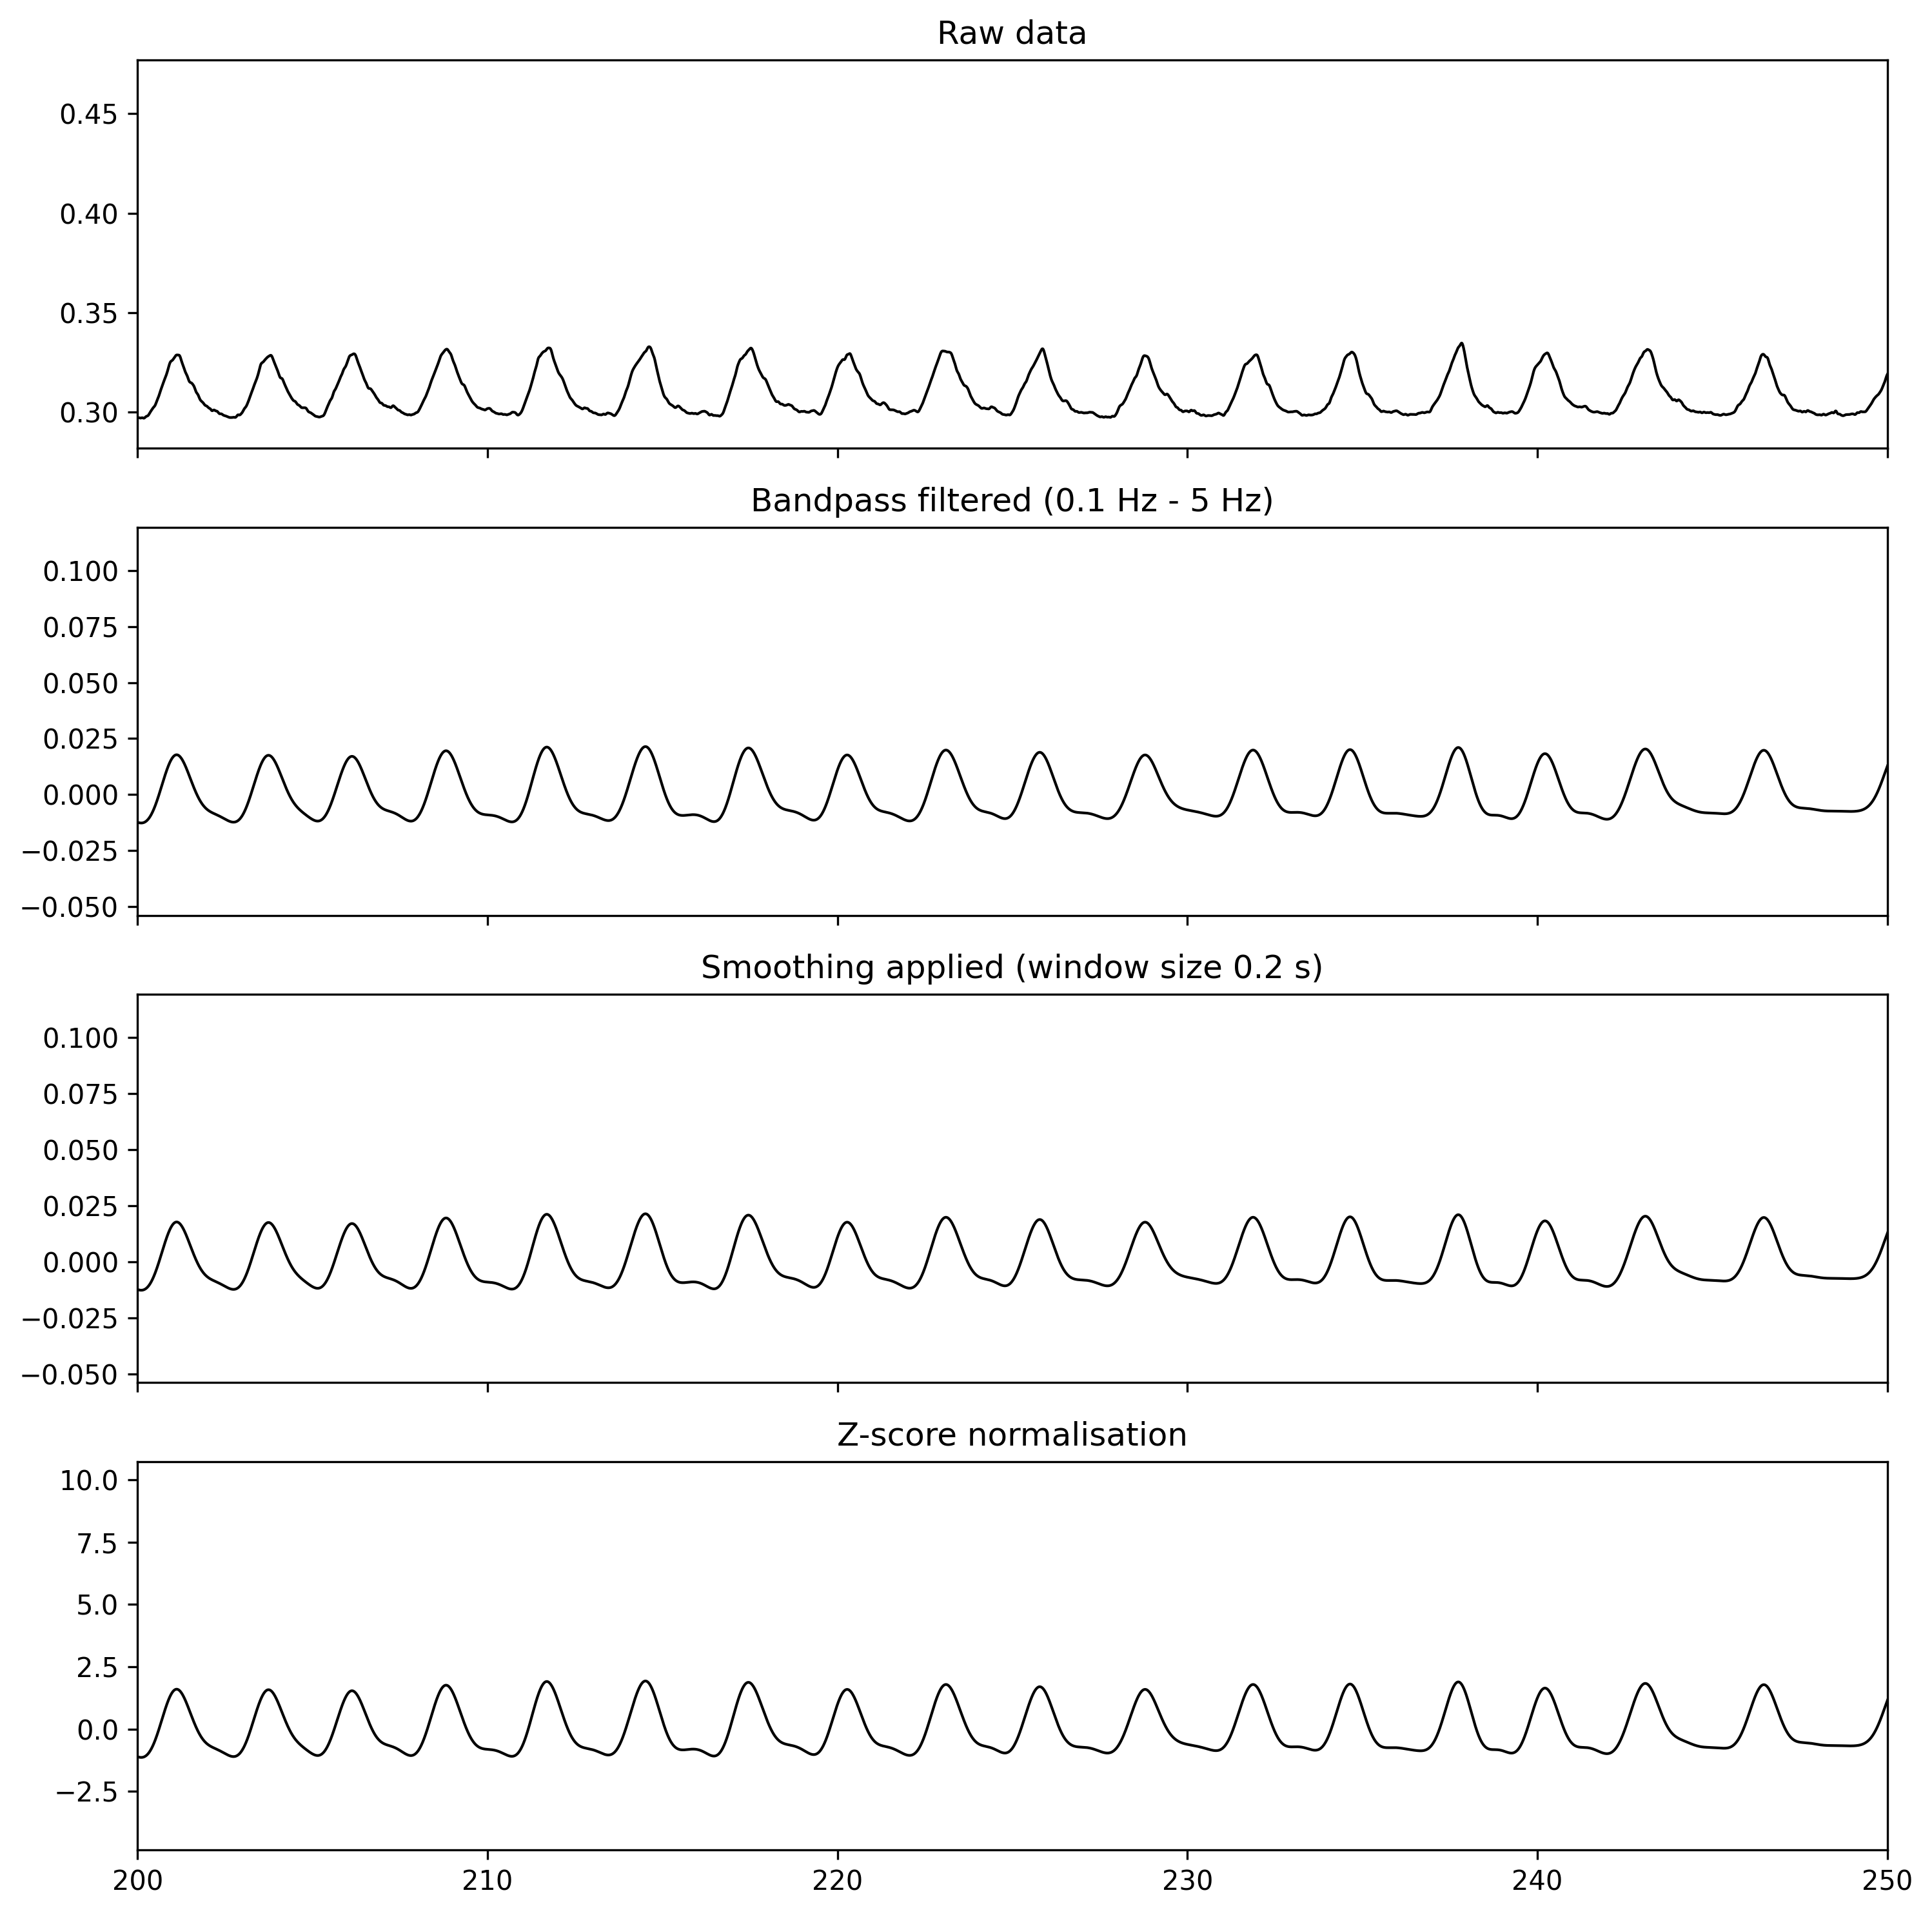

In [ ]:

resp_data = data["respiration_timeseries"].get_data().squeeze()
sfreq = data["respiration_timeseries"].info["sfreq"]

resp_ts = resp_data
n_samples = len(resp_ts)
times = np.arange(n_samples) / sfreq  

plot_kwargs = {
        "color": "k",
        "linewidth": 1
}


raw = RawSignal(resp_ts, fs = sfreq)

fig, axes = plt.subplots(4,1, dpi = 300, figsize = (10, 10), sharex=True)



axes[0].plot(times, raw.ts, **plot_kwargs)
axes[0].set_title("Raw data")

raw.filter_bandpass(low = 0.1, high = 1)
axes[1].plot(times, raw.ts, **plot_kwargs)
axes[1].set_title("Bandpass filtered (0.1 Hz - 5 Hz)")


window_size = 60
raw.smoothing(window_size = window_size)
axes[2].plot(times, raw.ts, **plot_kwargs)
axes[2].set_title(f"Smoothing applied (window size {window_size/sfreq} s)")


raw.zscore()
axes[3].plot(times, raw.ts, **plot_kwargs)
axes[3].set_title(f"Z-score normalisation")

axes[3].set_xlim(200, 250)

fig.tight_layout()
